# Network Analysis

In [1]:
import re, json, glob, csv, sys, os, warnings
import pandas as pd
import numpy as np
import itertools as iter
import networkx as nx
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import community
from networkx.readwrite import json_graph
from json import JSONEncoder
from operator import itemgetter
from collections import Counter
   
# Import project-specific functions. 
# Python files (.py) have to be in same folder to work.
lib_path = os.path.abspath(os.path.join(os.path.dirname('JQA_XML_parser.py'), '../Scripts'))
sys.path.append(lib_path)
from JQA_XML_parser import *

# Read in config.py (git ignored file) for API username and pw.
config_path = os.path.abspath(os.path.join(os.path.dirname('config.py'), '../Scripts'))
sys.path.append(config_path)
import config

# Ignore warnings related to deprecated functions.
warnings.filterwarnings('ignore')

url = 'https://dsg.xmldb-dev.northeastern.edu/BaseX964/rest/psc/'
user = config.username
pw = config.password

## Gather XML Files

In [2]:
%%time

# Must be connected to Northeastern's VPN.
r = requests.get(url, 
                 auth = (user, pw), 
                 headers = {'Content-Type': 'application/xml'}
                )

# Read in contents of pipeline.
soup = BeautifulSoup(r.content, 'html.parser')

# Split soup's content by \n (each line is a file path to an XML doc).
# Use filter() to remove empty strings ('').
# Convert back to list using list().
files = list(filter(None, soup.text.split('\n')))

# Filter list and retrieve only jqa/ files.
files = [i for i in files if 'jqa/' in i]

len(files)

CPU times: user 57.5 ms, sys: 8.05 ms, total: 65.5 ms
Wall time: 551 ms


607

## Build Dataframe

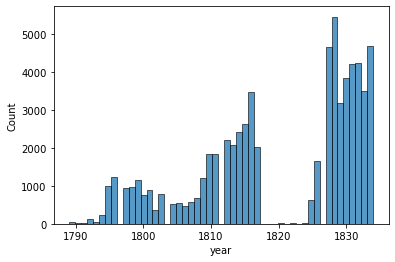

CPU times: user 12.4 s, sys: 863 ms, total: 13.3 s
Wall time: 3min 54s


,file,entry,date,people,subjects,text,year
8,"('JQADiaries-v12-1789-09-p235.xml',)",jqadiaries-v12-1789-09-14,1789-09-14,willkings-katharine,Slave Trade,14th: After a detention of four days the wind...,1789
8,"('JQADiaries-v12-1789-09-p235.xml',)",jqadiaries-v12-1789-09-14,1789-09-14,u,Slave Trade,14th: After a detention of four days the wind...,1789
8,"('JQADiaries-v12-1789-09-p235.xml',)",jqadiaries-v12-1789-09-14,1789-09-14,winslow-edward2,Slave Trade,14th: After a detention of four days the wind...,1789


In [3]:
%%time

# Build dataframe from XML files.
# build_dataframe() called from Correspondence_XML_parser
df = build_dataframe(files, url, user, pw)

# Unnest subject headings. 
df['people'] = df['people'].str.split(r',|;')
df = df.explode('people')

# Remove leading and trailing whitespace.
df['people'] = df['people'].str.strip()

# Remove rows with empty values.
df.replace('', np.nan, inplace = True)
df.dropna(inplace = True)

# Convert to datetime and extract year.
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

df['year'] = df['date'].dt.year

# Chart distribution of weights.
sns.histplot(data = df, x = 'year')

plt.show()

df.head(3)

## Create Adjacency Matrix

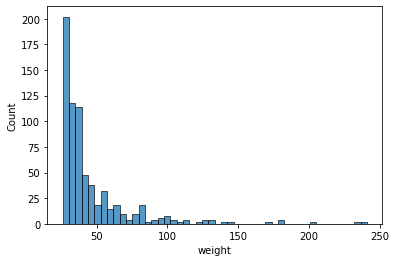

CPU times: user 7min 58s, sys: 5.19 s, total: 8min 3s
Wall time: 8min 8s


In [12]:
%%time

# Filter dates by distribution.
df = df.query('(people != "u") & (people != "source")') 
    #.query('(date < "1800-01-01") | (date >= "1830-01-01")')

# Create adjacency matrix.
adj = pd.crosstab(df['entry'], df['people'])

# Convert entry-person matrix into an adjacency matrix of persons.
adj = adj.T.dot(adj)

# Change same-same connections to zero.
np.fill_diagonal(adj.values, 0)

# # Simple correlation matrix from dataframe.
# adj = adj.corr()

adj['source'] = adj.index

df_graph = pd.melt(adj, id_vars = 'source', var_name = 'target', value_name = 'weight') \
    .query('(source != target) & (weight > 15)') # 20 is good

# Chart distribution of weights.
sns.histplot(data = df_graph, x = 'weight')

plt.show()

## Create Graph Object

In [44]:
%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(df_graph, 'source', 'target', 'weight')

# Add nodes.
nodes = list( dict.fromkeys( df_graph['source'].values.tolist() + df_graph['target'].values.tolist() ))
nodes = pd.DataFrame(nodes, columns = ['source'])
G.add_nodes_from(nodes)

print (nx.info(G))

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree')

# Sort nodes by degree and print top results.
sorted_degree = sorted(dict(G.degree(G.nodes())).items(),
                       key = itemgetter(1), reverse = True)

print ("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print (f'\t{d}')

# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Related to diameter, check if network is connected and, therefore, can have a diameter.
print (f"Is the network connected? {nx.is_connected(G)}")

# Find triadic closure (similar to density).
triadic_closure = nx.transitivity(G)
print (f"Triadic closure: {triadic_closure:.3f}\n")


# Get a list of network components (communities).
# Find the largest component.
components = nx.connected_components(G)
largest_component = max(components, key = len)

# Create a subgraph of the largest component and measure its diameter.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print (f"Network diameter of the largest component: {diameter:.3f}")

# Find centrality measures. 
betweenness_dict = nx.betweenness_centrality(subgraph) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(subgraph) # Run eigenvector centrality
degree_cent_dict = nx.degree_centrality(subgraph)

# Assign each centrality measure to an attribute.
nx.set_node_attributes(subgraph, betweenness_dict, 'betweenness')
nx.set_node_attributes(subgraph, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(subgraph, degree_cent_dict, 'degree_cent')

# Find communities. naive_greedy_modularity_communities
communities = community.naive_greedy_modularity_communities(subgraph)
# communities = community.k_clique_communities(subgraph, 5)
# communities = community.greedy_modularity_communities(subgraph)
# communities = community.kernighan_lin_bisection(subgraph)

# Create a dictionary that maps nodes to their community.
modularity_dict = {}
for i, c in enumerate(communities):
    for name in c:
        modularity_dict[name] = i
        
# Add modularity information to graph object.
nx.set_node_attributes(subgraph, modularity_dict, 'modularity')

Name: 
Type: Graph
Number of nodes: 149
Number of edges: 350
Average degree:   4.6980
Top 10 nodes by degree:
	('adams-louisa-catherine', 40)
	('jackson-andrew', 29)
	('gallatin-albert', 26)
	('harris-levett', 25)
	('alexander-i', 24)
	('southard-samuel', 24)
	('adams-charles2', 23)
	('bayard-james', 20)
	('adams-john2', 18)
	('barbour-james', 16)
Network density: 0.032
Is the network connected? False
Triadic closure: 0.321

Network diameter of the largest component: 9.000
CPU times: user 25min 43s, sys: 8.14 s, total: 25min 51s
Wall time: 26min 9s


## Write Graph Object

In [45]:
%%time

# Convert graph object into a dictionary.
data = json_graph.node_link_data(subgraph)

# # Serialize dictionary with json.
# class NPEncoder(JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return JSONEncoder.default(self, obj)
    
# data_json = json.dumps(data, cls=NPEncoder)

with open("/Users/quinn.wi/Documents/" + "Github/dsg-mhs/lab_space/projects/jqa/coref/data/jqa_coRef-network.json", 
          "w") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)
#     f.write(data_json)

CPU times: user 6.46 ms, sys: 1.7 ms, total: 8.16 ms
Wall time: 6.87 ms
